In [1]:
# based on tutorial @ https://www.youtube.com/watch?v=4FmVIpcwl4k

# this model is, if you can possibly imagine this, WORSE than LSTM_0

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [2]:
df = pd.read_csv('/Users/jonathanlifferth/PycharmProjects/longevity_solutions_ml/0_master_df.csv')
df = df.drop(columns=['Unnamed: 0'])
df

,datetime,HR,glucose,Vertical,Lateral,Sagittal
0,2014-10-01 19:14:00,68,185.4,1979,2053,2095
1,2014-10-01 19:14:00,68,185.4,1979,2053,2096
2,2014-10-01 19:14:00,68,185.4,1980,2052,2098
3,2014-10-01 19:14:00,68,185.4,1976,2052,2098
4,2014-10-01 19:14:00,68,185.4,1978,2052,2098
...,...,...,...,...,...,...
1309195,2014-10-04 13:44:00,62,131.4,2018,1990,1990
1309196,2014-10-04 13:44:00,62,131.4,2018,1990,1991
1309197,2014-10-04 13:44:00,62,131.4,2017,1991,1990
1309198,2014-10-04 13:44:00,62,131.4,2017,1989,1991


In [3]:
df = df.drop_duplicates(subset=['datetime'])
df

,datetime,HR,glucose,Vertical,Lateral,Sagittal
0,2014-10-01 19:14:00,68,185.4,1979,2053,2095
6000,2014-10-01 19:19:00,87,178.2,1970,2051,2084
12000,2014-10-01 19:23:00,66,169.2,1985,2001,2009
18000,2014-10-01 19:24:00,75,176.4,1965,2038,2064
24000,2014-10-01 19:29:00,93,172.8,1964,2033,2043
...,...,...,...,...,...,...
1291600,2014-10-04 13:04:00,70,72.0,1989,2067,2099
1292600,2014-10-04 13:09:00,70,79.2,1956,2013,2058
1296800,2014-10-04 13:19:00,50,97.2,1967,2019,2054
1302400,2014-10-04 13:24:00,70,106.2,1969,2028,2057


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318 entries, 0 to 1303400
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  318 non-null    object 
 1   HR        318 non-null    int64  
 2   glucose   318 non-null    float64
 3   Vertical  318 non-null    int64  
 4   Lateral   318 non-null    int64  
 5   Sagittal  318 non-null    int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 17.4+ KB


In [5]:
df['datetime'] = pd.to_datetime(df['datetime'],infer_datetime_format=True)
df

/var/folders/sw/bhwsqj457gg7f1ycx1_p1j480000gn/T/ipykernel_2188/113577199.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = pd.to_datetime(df['datetime'],infer_datetime_format=True)


,datetime,HR,glucose,Vertical,Lateral,Sagittal
0,2014-10-01 19:14:00,68,185.4,1979,2053,2095
6000,2014-10-01 19:19:00,87,178.2,1970,2051,2084
12000,2014-10-01 19:23:00,66,169.2,1985,2001,2009
18000,2014-10-01 19:24:00,75,176.4,1965,2038,2064
24000,2014-10-01 19:29:00,93,172.8,1964,2033,2043
...,...,...,...,...,...,...
1291600,2014-10-04 13:04:00,70,72.0,1989,2067,2099
1292600,2014-10-04 13:09:00,70,79.2,1956,2013,2058
1296800,2014-10-04 13:19:00,50,97.2,1967,2019,2054
1302400,2014-10-04 13:24:00,70,106.2,1969,2028,2057


array([<AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
       <AxesSubplot:xlabel='datetime'>], dtype=object)

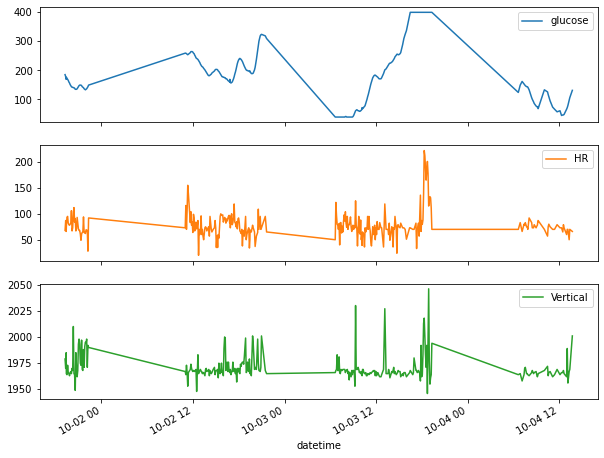

In [6]:
df.set_index('datetime')[['glucose', 'HR', 'Vertical']].plot(subplots=True)

In [7]:
df.describe()

,HR,glucose,Vertical,Lateral,Sagittal
count,318.000000,318.000000,318.000000,318.000000,318.000000
mean,78.333333,183.622642,1970.503145,2032.707547,2057.493711
std,25.683874,99.936043,11.843818,17.577032,23.652685
min,20.000000,39.600000,1946.000000,1969.000000,1973.000000
25%,66.250000,124.650000,1965.000000,2021.000000,2046.000000
50%,73.000000,178.200000,1967.000000,2033.000000,2057.000000
75%,85.000000,234.000000,1970.000000,2043.000000,2067.750000
max,222.000000,399.600000,2046.000000,2092.000000,2115.000000


In [8]:
df['datetime']=df['datetime'].apply(lambda x: x.toordinal())
df = df.set_index('datetime')
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)

# had errors with this previously, found solution at 
# https://stackoverflow.com/questions/62759022/typeerror-invalid-type-promotion-while-fitting-a-logistic-regression-model-in-s/62965516#62965516
# df['date']=df['date'].apply(lambda x: x.toordinal())

/var/folders/sw/bhwsqj457gg7f1ycx1_p1j480000gn/T/ipykernel_2188/1098387919.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime']=df['datetime'].apply(lambda x: x.toordinal())


In [42]:
data_scaled
data_scaled.shape

(318, 5)

In [10]:
features = data_scaled
target = data_scaled[:,0]

In [11]:
TimeseriesGenerator(features, target, length=2, sampling_rate=1, batch_size=1)[0]

(array([[[0.23762376, 0.405     , 0.33      , 0.68292683, 0.85915493],
         [0.33168317, 0.385     , 0.24      , 0.66666667, 0.78169014]]]),
 array([0.22772277]))

In [12]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=123, shuffle=False)

In [13]:
x_train.shape

(254, 5)

In [14]:
x_test.shape

(64, 5)

In [23]:
# not very confident about these parameter selections

win_length = 12
batch_size = 12
num_features = 5
train_generator = TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

In [17]:
train_generator[0]

(array([[[0.23762376, 0.405     , 0.33      , 0.68292683, 0.85915493],
         [0.33168317, 0.385     , 0.24      , 0.66666667, 0.78169014],
         [0.22772277, 0.36      , 0.39      , 0.2601626 , 0.25352113],
         [0.27227723, 0.38      , 0.19      , 0.56097561, 0.64084507],
         [0.36138614, 0.37      , 0.18      , 0.5203252 , 0.49295775],
         [0.37128713, 0.36      , 0.27      , 0.55284553, 0.65492958],
         [0.30693069, 0.35      , 0.2       , 0.51219512, 0.66197183],
         [0.29207921, 0.335     , 0.19      , 0.43902439, 0.61267606],
         [0.28712871, 0.325     , 0.17      , 0.45528455, 0.50704225],
         [0.2970297 , 0.31      , 0.2       , 0.42276423, 0.52816901],
         [0.30693069, 0.3       , 0.21      , 0.47154472, 0.66197183],
         [0.42574257, 0.29      , 0.19      , 0.51219512, 0.58450704]],
 
        [[0.33168317, 0.385     , 0.24      , 0.66666667, 0.78169014],
         [0.22772277, 0.36      , 0.39      , 0.2601626 , 0.25352113],
   

In [19]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape=(win_length, num_features), return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(64, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 12, 128)           68608     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 12, 128)           131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 12, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)               

In [24]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                 patience=2,
                                                 mode='min')

model.compile(loss=tf.losses.MeanSquaredError(),
             optimizer=tf.optimizers.Adam(),
             metrics=[tf.metrics.MeanAbsoluteError()])

history = model.fit_generator(train_generator, epochs=50,
                             validation_data=test_generator,
                             shuffle=False,
                             callbacks=[early_stopping])

/Users/jonathanlifferth/PycharmProjects/longevity_solutions_ml/venv/lib/python3.9/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-10-18 19:58:00.250228: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
21/21 [==============================] - 5s 51ms/step - loss: 0.0187 - mean_absolute_error: 0.1017 - val_loss: 0.0697 - val_mean_absolute_error: 0.1483
Epoch 2/50
21/21 [==============================] - 0s 15ms/step - loss: 0.0101 - mean_absolute_error: 0.0799 - val_loss: 0.0812 - val_mean_absolute_error: 0.1747
Epoch 3/50
21/21 [==============================] - 0s 14ms/step - loss: 0.0099 - mean_absolute_error: 0.0746 - val_loss: 0.0655 - val_mean_absolute_error: 0.1426
Epoch 4/50
21/21 [==============================] - 0s 14ms/step - loss: 0.0093 - mean_absolute_error: 0.0739 - val_loss: 0.0648 - val_mean_absolute_error: 0.1417
Epoch 5/50
21/21 [==============================] - 0s 15ms/step - loss: 0.0091 - mean_absolute_error: 0.0725 - val_loss: 0.0688 - val_mean_absolute_error: 0.1513
Epoch 6/50
21/21 [==============================] - 0s 15ms/step - loss: 0.0099 - mean_absolute_error: 0.0752 - val_loss: 0.0684 - val_mean_absolute_error: 0.1504


In [25]:
model.evaluate_generator(test_generator, verbose=0)

/Users/jonathanlifferth/PycharmProjects/longevity_solutions_ml/venv/lib/python3.9/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.0684436485171318, 0.15040451288223267]

In [26]:
predictions=model.predict_generator(test_generator)

/Users/jonathanlifferth/PycharmProjects/longevity_solutions_ml/venv/lib/python3.9/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [27]:
predictions.shape[0]

52

In [28]:
predictions

array([[0.21507175],
       [0.21265514],
       [0.21603288],
       [0.21719429],
       [0.2182614 ],
       [0.2190531 ],
       [0.22265278],
       [0.2260939 ],
       [0.2277063 ],
       [0.2312565 ],
       [0.23151502],
       [0.23219047],
       [0.23466139],
       [0.23242404],
       [0.22922254],
       [0.22792895],
       [0.22697715],
       [0.2271892 ],
       [0.22584347],
       [0.22675596],
       [0.22862156],
       [0.22957638],
       [0.23310696],
       [0.23472956],
       [0.23781824],
       [0.24121316],
       [0.23896031],
       [0.23845182],
       [0.23830378],
       [0.23718567],
       [0.23839836],
       [0.23749833],
       [0.23594494],
       [0.23856811],
       [0.24087234],
       [0.24262385],
       [0.24434353],
       [0.24594112],
       [0.24449365],
       [0.24382336],
       [0.24355616],
       [0.24359444],
       [0.24180841],
       [0.23995711],
       [0.23854609],
       [0.23734133],
       [0.23919274],
       [0.238

In [29]:
y_test

array([0.30693069, 0.06435644, 0.24752475, 0.27227723, 0.30693069,
       0.18316832, 0.37623762, 0.57425743, 0.22772277, 0.33168317,
       0.2970297 , 0.33663366, 0.58415842, 1.        , 0.95049505,
       0.83663366, 0.71782178, 0.81683168, 0.8960396 , 0.78217822,
       0.47029703, 0.53960396, 0.55940594, 0.54950495, 0.45544554,
       0.24752475, 0.24752475, 0.31188119, 0.22772277, 0.2970297 ,
       0.28712871, 0.31188119, 0.27227723, 0.27227723, 0.24752475,
       0.35643564, 0.31188119, 0.26237624, 0.26237624, 0.29207921,
       0.26237624, 0.27722772, 0.28712871, 0.33168317, 0.33168317,
       0.24752475, 0.18316832, 0.27227723, 0.2970297 , 0.27227723,
       0.24752475, 0.24752475, 0.29207921, 0.26237624, 0.26237624,
       0.22277228, 0.29207921, 0.26237624, 0.1980198 , 0.24752475,
       0.24752475, 0.14851485, 0.24752475, 0.22772277])

In [30]:
x_test

array([[0.30693069, 1.        , 0.22      , 0.66666667, 0.69014085],
       [0.06435644, 1.        , 0.22      , 0.38211382, 0.55633803],
       [0.24752475, 1.        , 0.2       , 0.56097561, 0.64084507],
       [0.27227723, 1.        , 0.21      , 0.64227642, 0.64084507],
       [0.30693069, 1.        , 0.22      , 0.69105691, 0.64084507],
       [0.18316832, 1.        , 0.2       , 0.56910569, 0.50704225],
       [0.37623762, 1.        , 0.2       , 0.48780488, 0.49295775],
       [0.57425743, 1.        , 0.12      , 0.52845528, 0.58450704],
       [0.22772277, 1.        , 0.46      , 0.3495935 , 0.1971831 ],
       [0.33168317, 1.        , 0.16      , 0.56097561, 0.65492958],
       [0.2970297 , 1.        , 0.18      , 0.54471545, 0.6056338 ],
       [0.33663366, 1.        , 0.37      , 0.30894309, 0.21830986],
       [0.58415842, 1.        , 0.67      , 0.42276423, 0.09859155],
       [1.        , 1.        , 0.72      , 0.28455285, 0.04929577],
       [0.95049505, 1.        , 0.

In [31]:
x_test[:,1:][win_length:]

array([[1.        , 0.67      , 0.42276423, 0.09859155],
       [1.        , 0.72      , 0.28455285, 0.04929577],
       [1.        , 0.53      , 0.19512195, 0.24647887],
       [1.        , 0.37      , 0.26829268, 0.23943662],
       [1.        , 0.25      , 0.29268293, 0.22535211],
       [1.        , 0.46      , 0.26829268, 0.26760563],
       [1.        , 0.        , 0.29268293, 0.20422535],
       [1.        , 0.47      , 0.17073171, 0.26760563],
       [1.        , 1.        , 0.28455285, 0.        ],
       [1.        , 0.31      , 0.34146341, 0.33802817],
       [1.        , 0.09      , 0.6097561 , 0.55633803],
       [1.        , 0.15      , 0.5203252 , 0.52112676],
       [1.        , 0.18      , 0.54471545, 0.61971831],
       [1.        , 0.48      , 1.        , 0.67605634],
       [0.235     , 0.18      , 0.52845528, 0.61267606],
       [0.305     , 0.19      , 0.52845528, 0.65492958],
       [0.34      , 0.12      , 0.69105691, 0.71830986],
       [0.315     , 0.18      ,

In [33]:
df_pred=pd.concat([pd.DataFrame(predictions), pd.DataFrame(x_test[:,1:][win_length:])],axis=1)
df_pred

,0,0,1,2,3
0,0.215072,1.000,0.67,0.422764,0.098592
1,0.212655,1.000,0.72,0.284553,0.049296
2,0.216033,1.000,0.53,0.195122,0.246479
3,0.217194,1.000,0.37,0.268293,0.239437
4,0.218261,1.000,0.25,0.292683,0.225352
5,0.219053,1.000,0.46,0.268293,0.267606
6,0.222653,1.000,0.00,0.292683,0.204225
7,0.226094,1.000,0.47,0.170732,0.267606
8,0.227706,1.000,1.00,0.284553,0.000000
9,0.231256,1.000,0.31,0.341463,0.338028


In [35]:
rev_trans=scaler.inverse_transform(df_pred)
rev_trans

array([[  63.44449404,  399.6       , 2013.        , 2021.        ,
        1987.        ],
       [  62.95633867,  399.6       , 2018.        , 2004.        ,
        1980.        ],
       [  63.63864127,  399.6       , 1999.        , 1993.        ,
        2008.        ],
       [  63.87324637,  399.6       , 1983.        , 2002.        ,
        2007.        ],
       [  64.08880398,  399.6       , 1971.        , 2005.        ,
        2005.        ],
       [  64.24872711,  399.6       , 1992.        , 2002.        ,
        2011.        ],
       [  64.97586116,  399.6       , 1946.        , 2005.        ,
        2002.        ],
       [  65.67096844,  399.6       , 1993.        , 1990.        ,
        2011.        ],
       [  65.99667224,  399.6       , 2046.        , 2004.        ,
        1973.        ],
       [  66.71381298,  399.6       , 1977.        , 2011.        ,
        2021.        ],
       [  66.76603407,  399.6       , 1955.        , 2044.        ,
        2052

In [37]:
df_final=df[predictions.shape[0]*-1:]

In [38]:
df_final.count()

HR          52
glucose     52
Vertical    52
Lateral     52
Sagittal    52
dtype: int64

In [40]:
df_final['App_Pred']=rev_trans[:,0]
df_final

/var/folders/sw/bhwsqj457gg7f1ycx1_p1j480000gn/T/ipykernel_2188/3996761978.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['App_Pred']=rev_trans[:,0]


,HR,glucose,Vertical,Lateral,Sagittal,App_Pred
datetime,,,,,,
735509,138,399.6,2013,2021,1987,63.444494
735509,222,399.6,2018,2004,1980,62.956339
735509,212,399.6,1999,1993,2008,63.638641
735509,189,399.6,1983,2002,2007,63.873246
735509,165,399.6,1971,2005,2005,64.088804
735509,185,399.6,1992,2002,2011,64.248727
735509,201,399.6,1946,2005,2002,64.975861
735509,178,399.6,1993,1990,2011,65.670968
735509,115,399.6,2046,2004,1973,65.996672


<AxesSubplot:xlabel='datetime'>

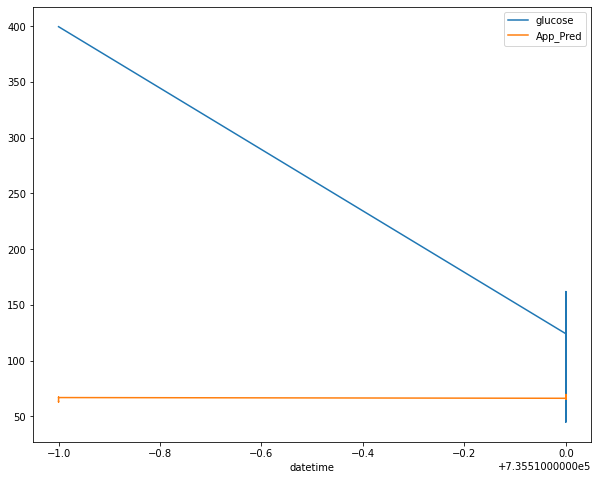

In [41]:
df_final[['glucose','App_Pred']].plot()